## Iris Classification Neural Network
Custom network and training and procedure for classification

### Must Remember points
**TensorDataset and Trainloader help avoid data type mismatch**  
**Functional is deprecated use torch.activation_function**  
**Cross entropy loss function requires only the logits or the linear ouput values**  
**Instead of softmax from experience it is better to use log_softmax with a NLLLoss function**  
**View at the start of the forward method in the model is very important**  
**Always use a custom Softmax function to check if that the forward method works properly**
**Validation code changes according to the final activation function being used**

In [565]:
from sklearn import datasets
import torch
from torch import nn
from sklearn import model_selection
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [202]:
data = datasets.load_iris()
x = data['data']
y = data['target']

In [203]:
x_train, x_val, y_train, y_val = model_selection.train_test_split(data.data,data.target,test_size = 0.2)

In [552]:
x_tr_ten = torch.FloatTensor(x_train)
y_tr_ten = torch.LongTensor(y_train)

trainloader = TensorDataset(x_tr_ten,y_tr_ten)

x_te_ten = torch.FloatTensor(x_val)
y_te_ten = torch.LongTensor(y_val)

testloader = TensorDataset(x_te_ten,y_te_ten)

In [553]:
trainer = DataLoader(trainloader,batch_size=5)
tester = DataLoader(testloader,batch_size=5)

In [460]:
class Model(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        self.hidden1 = nn.Linear(4,10)
        self.hidden2 = nn.Linear(10,10)
        self.hidden3 = nn.Linear(10,8)
        self.output = nn.Linear(8,3)
        
    def forward(self,x):
        
        #Incorrect answer
        x = x.view(-1,4)
        
        #This is incorrect
        #x=x.view(x.shape[0],-1)
        
        x = torch.sigmoid(self.hidden1(x))
        x = torch.sigmoid(self.hidden2(x))
        x = torch.sigmoid(self.hidden3(x))
        
        #This is incorrect
        #x = torch.log_softmax(self.output(x),dim=0)
        x = torch.log_softmax(self.output(x),dim=1)
        
        return x

In [661]:
#Experimental code to understand the working
# t = torch.rand(1,4)
# t = t.view(-1,4)
# t.shape

# x_tr_ten[0].shape

# output = mod(next(iter(trainer))[0])
# output.shape

# final = torch.softmax(output,dim=1)
# final

# next(iter(trainer))[1]

# sample=x_tr_ten[0]
# answer=y_tr_ten[0]
# sample,answer

# out = mod(sample)
# print(out.shape)

# out

# def softmax(x):
#     return torch.exp(x)/torch.sum(torch.exp(x), dim=1).view(-1, 1)

# prob = torch.softmax(out,dim=1)
# loss_function(prob,answer.view(1))

# samples

# model_trial = Model()
# samples,labels = next(iter(trainer))
# output = model_trial(samples)
# ps = torch.exp(output)
# print(labels)
# print(ps)
# maxi = torch.eq(torch.max(ps,dim=1)[1],labels).view(-1)  #------------->View is needed for the sum being the total of 5 values
# sum(maxi).item()
# maxi.shape[0]

# epoch = 2

# for i in range(epoch):
#     running_loss = 0
#     for features,targets in trainer:
        
#         optimizer.zero_grad()
    
#         loss = loss_function(mod(features.to(device)),targets.to(device))
#         loss.backward()
#         optimizer.step()
        
#         running_loss+= loss.item()
        
#     else:
#         print("Training loss: " + str(running_loss/len(trainer)))
        

In [701]:
mod = Model()
loss_function = nn.NLLLoss()
#optimizer = torch.optim.SGD(mod.parameters(),lr=0.01)
optimizer = torch.optim.Adam(mod.parameters(),lr=0.03)

In [702]:
if torch.cuda.is_available:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

mod.to(device)

Model(
  (hidden1): Linear(in_features=4, out_features=10, bias=True)
  (hidden2): Linear(in_features=10, out_features=10, bias=True)
  (hidden3): Linear(in_features=10, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=3, bias=True)
)

In [763]:
def train(model,optimizer,loss_fun,trainloader,testloader,epochs=15,device="cuda"):
    
    tr_list = []
    val_list = []
    acc_list = []
    epoch_list = [i+1 for i in range(epochs)]
    
    for epoch in range(epochs):
        
        training_loss = 0
        validation_loss = 0
        model.train()                #--------------------->Allows for parameters to be updated by backpropagation
        
        for batch in trainloader:
            
            optimizer.zero_grad()
            inputs,labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = loss_fun(outputs,labels)
            loss.backward()
            optimizer.step()
            
            training_loss += loss.item()
        
        model.eval()              #------------------------>Freezes the parameters for model validation
        correct_pred = 0
        total_pred = 0
        
        for batch in testloader:
            
            inputs,labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = loss_fun(outputs,labels)
            
            validation_loss +=loss.item()
            
            ps = torch.exp(outputs)         #-------------->The final activation function is Log_Softmax that's why we take exp
            
            correct = torch.eq(torch.max(ps,dim=1)[1],labels).view(-1)
            
            correct_pred += torch.sum(correct).item()
            total_pred += correct.shape[0]       #--------->Alternatively can also write batch.shape[0]
            
        training_loss = training_loss/len(trainloader)
        validation_loss = validation_loss/len(testloader)
        
        tr_list.append(training_loss)
        val_list.append(validation_loss)
        acc_list.append((correct_pred*100.0/total_pred))
            
        print("Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}"
              .format(epoch+1, training_loss,validation_loss, correct_pred * 100.0 / total_pred))
    
    fig = plt.figure(figsize=(20,6))
        
    plt.subplot(1,3,1)
    plt.plot(epoch_list,tr_list)
    plt.title("Training Loss")
    plt.xlabel("Epochs")
    
    plt.subplot(1,3,2)
    plt.plot(epoch_list,val_list)
    plt.title("Validation Loss")
    plt.xlabel("Epochs")
    
    plt.subplot(1,3,3)
    plt.plot(epoch_list,acc_list)
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.savefig("No_opti.png")
    
    plt.show()

In [787]:
seq = nn.Sequential(nn.Linear(4,8),nn.ReLU(),nn.Linear(8,3),nn.LogSoftmax(dim=1))
criterion_seq = nn.NLLLoss()
optimizer_seq = torch.optim.SGD(seq.parameters(),lr=0.008)
seq.to(device)

Sequential(
  (0): Linear(in_features=4, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=3, bias=True)
  (3): LogSoftmax()
)

Epoch: 1, Training Loss: 1.25, Validation Loss: 1.14, accuracy = 26.67
Epoch: 2, Training Loss: 1.05, Validation Loss: 1.02, accuracy = 56.67
Epoch: 3, Training Loss: 0.96, Validation Loss: 0.94, accuracy = 56.67
Epoch: 4, Training Loss: 0.89, Validation Loss: 0.88, accuracy = 56.67
Epoch: 5, Training Loss: 0.82, Validation Loss: 0.82, accuracy = 56.67
Epoch: 6, Training Loss: 0.76, Validation Loss: 0.77, accuracy = 56.67
Epoch: 7, Training Loss: 0.71, Validation Loss: 0.73, accuracy = 56.67
Epoch: 8, Training Loss: 0.67, Validation Loss: 0.69, accuracy = 60.00
Epoch: 9, Training Loss: 0.63, Validation Loss: 0.65, accuracy = 60.00
Epoch: 10, Training Loss: 0.59, Validation Loss: 0.62, accuracy = 60.00


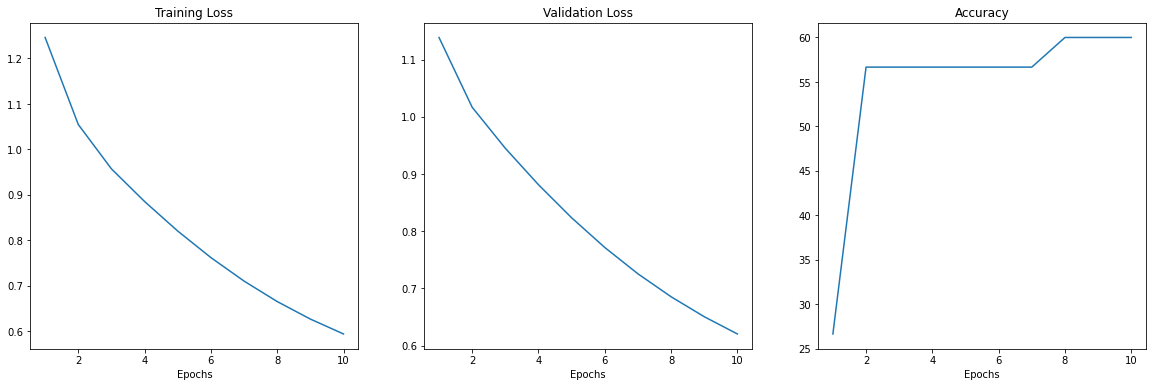

In [788]:
train(seq,optimizer_seq,criterion_seq,trainer,tester,10)

In [752]:
import torchsummary

In [794]:
%%capture cap --no-stderr
torchsummary.summary(seq,(1,4),batch_size=5)
with open('out.txt', 'w') as f:
    f.write(cap.stdout)